<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/VAE%E3%81%AE%E6%BD%9C%E5%9C%A8%E7%A9%BA%E9%96%93%E3%81%AB%E3%81%8A%E3%81%91%E3%82%8B%E7%95%B0%E5%B8%B8%E6%A4%9C%E7%9F%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Variational Autoencoder (VAE) + PCA による異常検知 (MNIST)
# - VAE を正常データのみ（ある数字クラス）で学習
# - 特徴量 = [mid 平均(64) | mid 標準偏差(64) | 潜在平均 z_mu(32)] = 160次元
# - 標準化（train-normal にフィット） -> PCA(2次元)（train-normal にフィット）
# - スコア = PCA-2D 空間における Mahalanobis 距離（train-normal 分布に対して）
# - 可視化: PCA 散布図 + 楕円 + しきい値, ヒストグラム, ROC,
#           潜在平均 z_mu の散布図 (PCA), 再構成ギャラリー
# VAE の損失は recon(MSE) + β * KL。安定化のため、KL の重みは線形にウォームアップします。
# - 特徴量には潜在平均 (z_mu) を使用します（決定的）。確率的なスコアリングが良ければ、  z を複数回サンプリングしてスコアを平均化できますが、ここでは簡潔さを優先しています。
# - しきい値は train-normal の距離の p パーセンタイルで設定します。必要に応じて THRESH_PCT を調整してください。

import os, random, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms


In [2]:
# sklearn の読み込み（未インストールならインストール）
try:
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, auc
except Exception:
    import subprocess; subprocess.call(["pip","-q","install","scikit-learn"])
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, auc

In [3]:
# ===== 設定 =====
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
BATCH = 128
EPOCHS = 12
LR = 1e-3
BETA = 1.0                 # β-VAE の β
KL_WARMUP_EPOCHS = 5       # KL のウォームアップ（線形増加）
NORMAL_DIGIT = 1           # 正常データとする数字 (0-9)
SAMPLE_PER_CLASS = 2000    # 散布図用にサンプルする数
THRESH_PCT = 99.0          # train-normal 距離のパーセンタイルを閾値に
N_VIZ = 8                  # ギャラリー表示数
SAVE_CSV = True

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

In [4]:
# ===== データ =====
tfm = transforms.Compose([transforms.ToTensor()])
root = "/content/data"
tr = datasets.MNIST(root, train=True,  download=True, transform=tfm)
te = datasets.MNIST(root, train=False, download=True, transform=tfm)

# 正常クラスと異常クラスのインデックスを作成
tr_norm_idx = [i for i,(_,y) in enumerate(tr) if y == NORMAL_DIGIT]
te_norm_idx = [i for i,(_,y) in enumerate(te) if y == NORMAL_DIGIT]
te_anom_idx = [i for i,(_,y) in enumerate(te) if y != NORMAL_DIGIT]

ds_bank = Subset(tr, tr_norm_idx)   # 学習用 (正常のみ)
ds_tn   = Subset(te, te_norm_idx)   # テスト正常
ds_ta   = Subset(te, te_anom_idx)   # テスト異常

# データローダ作成関数
def mk_loader(ds, shuffle=False, bs=BATCH):
    return DataLoader(ds, batch_size=bs, shuffle=shuffle, num_workers=2,
                      pin_memory=(DEVICE=="cuda"))

ld_bank = mk_loader(ds_bank, shuffle=True)
ld_tn   = mk_loader(ds_tn,   shuffle=False)
ld_ta   = mk_loader(ds_ta,   shuffle=False)

print(f"[DATA] normal={NORMAL_DIGIT} | bank={len(ds_bank)} | test_norm={len(ds_tn)} | test_anom={len(ds_ta)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 39.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 2.03MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


[DATA] normal=1 | bank=6742 | test_norm=1135 | test_anom=8865


In [6]:
# ===== モデル: ConvVAE (潜在 z_dim = 32) =====
class ConvVAE(nn.Module):
    def __init__(self, zdim=32):
        super().__init__()
        # Encoder 28->14->7
        self.e1 = nn.Sequential(
            nn.Conv2d(1,32,3,1,1), nn.ReLU(True),
            nn.Conv2d(32,32,3,1,1), nn.ReLU(True),
            nn.MaxPool2d(2)  # 28->14
        )
        self.e2 = nn.Sequential(
            nn.Conv2d(32,64,3,1,1), nn.ReLU(True),
            nn.Conv2d(64,64,3,1,1), nn.ReLU(True),
            nn.MaxPool2d(2)  # 14->7  (mid 特徴: [64,7,7])
        )
        self.fc_mu     = nn.Linear(64*7*7, zdim)
        self.fc_logvar = nn.Linear(64*7*7, zdim)

        # Decoder 7->14->28
        self.fc_up = nn.Linear(zdim, 64*7*7)
        self.d1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(64,32,3,1,1), nn.ReLU(True),
            nn.Conv2d(32,32,3,1,1), nn.ReLU(True)  # 14x14
        )
        self.d2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(32,16,3,1,1), nn.ReLU(True),
            nn.Conv2d(16, 1,3,1,1), nn.Sigmoid()   # 28x28
        )

    def encode(self, x, return_mid=False):
        h1 = self.e1(x)                  # [B,32,14,14]
        h2 = self.e2(h1)                 # [B,64,7,7] <-- mid
        flat = h2.flatten(1)
        mu = self.fc_mu(flat)            # [B,z]
        logvar = self.fc_logvar(flat)    # [B,z]
        if return_mid:
            return mu, logvar, h2
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_up(z).view(-1,64,7,7)
        h = self.d1(h)
        return self.d2(h)

    def forward(self, x):
        mu, logvar, mid = self.encode(x, return_mid=True)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, z, mu, logvar, mid

vae = ConvVAE(zdim=32).to(DEVICE)
opt = torch.optim.Adam(vae.parameters(), lr=LR)

# ===== 学習 (train-normal のみで VAE を学習) =====
def kl_divergence(mu, logvar):
    # KL(q(z|x) || N(0,1)) をサンプルごとに計算
    return 0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1.0 - logvar, dim=1)

vae.train()
for ep in range(1, EPOCHS+1):
    tot = 0.0; n = 0
    kl_w = BETA * min(1.0, ep / max(1, KL_WARMUP_EPOCHS))  # KL の線形ウォームアップ
    for x,_ in ld_bank:
        x = x.to(DEVICE, non_blocking=True)
        x_hat, z, mu, logvar, _ = vae(x)
        recon = F.mse_loss(x_hat, x, reduction="none").flatten(1).mean(1)  # サンプルごとの再構成誤差
        kl = kl_divergence(mu, logvar)
        loss = (recon + kl_w * kl).mean()
        opt.zero_grad(); loss.backward(); opt.step()
        bs = x.size(0); tot += float(loss)*bs; n += bs
    print(f"Epoch {ep:02d}/{EPOCHS}  loss={tot/max(1,n):.6f}  (KL_w={kl_w:.2f})")
vae.eval()
# ===== 特徴量抽出 =====
@torch.no_grad()
def extract_features(loader, keep_images=False):
    feats, z_mu_list = [], []
    xs, xh = [], []
    for x,_ in loader:
        x = x.to(DEVICE, non_blocking=True)
        x_hat, z, mu, logvar, mid = vae(x)        # mid: [B,64,7,7], mu: [B,32]
        # 画像レベルの mid 特徴統計量
        mu_mid = mid.mean(dim=(2,3))              # [B,64]
        sd_mid = mid.flatten(2).std(dim=2, unbiased=False)  # [B,64]
        f = torch.cat([mu_mid, sd_mid, mu], dim=1)  # [B,160]  (サンプル z ではなく z_mu を使用)
        feats.append(f.cpu().numpy())
        z_mu_list.append(mu.cpu().numpy())
        if keep_images:
            xs.append(x.cpu()); xh.append(x_hat.cpu())
    feats = np.concatenate(feats, axis=0)
    z_mu = np.concatenate(z_mu_list, axis=0)
    if keep_images:
        return feats, z_mu, torch.cat(xs,0), torch.cat(xh,0)
    return feats, z_mu



Epoch 01/12  loss=0.091959  (KL_w=0.20)
Epoch 02/12  loss=0.049247  (KL_w=0.40)
Epoch 03/12  loss=0.034856  (KL_w=0.60)
Epoch 04/12  loss=0.032339  (KL_w=0.80)
Epoch 05/12  loss=0.031593  (KL_w=1.00)
Epoch 06/12  loss=0.030241  (KL_w=1.00)
Epoch 07/12  loss=0.029445  (KL_w=1.00)
Epoch 08/12  loss=0.029199  (KL_w=1.00)
Epoch 09/12  loss=0.029099  (KL_w=1.00)
Epoch 10/12  loss=0.029059  (KL_w=1.00)
Epoch 11/12  loss=0.028969  (KL_w=1.00)
Epoch 12/12  loss=0.028961  (KL_w=1.00)


In [7]:
print("特徴量 (160次元) と潜在平均 z_mu (32次元) を抽出中 ...")
F_bank, Zb_mu = extract_features(ld_bank, keep_images=False)
F_tn,   Zn_mu, Xn, Xn_hat = extract_features(ld_tn, keep_images=True)
F_ta,   Za_mu, Xa, Xa_hat = extract_features(ld_ta, keep_images=True)

# ===== 標準化 & PCA(2次元) (train-normal のみにフィット) =====
scaler = StandardScaler().fit(F_bank)
Fb = scaler.transform(F_bank)
Fn = scaler.transform(F_tn)
Fa = scaler.transform(F_ta)

pca = PCA(n_components=2, random_state=SEED)
Pb = pca.fit_transform(Fb)
Pn = pca.transform(Fn)
Pa = pca.transform(Fa)
print(f"PCA 寄与率: {pca.explained_variance_ratio_}  (合計={pca.explained_variance_ratio_.sum():.3f})")

特徴量 (160次元) と潜在平均 z_mu (32次元) を抽出中 ...
PCA 寄与率: [0.22178195 0.13121983]  (合計=0.353)


In [8]:
# ===== PCA-2D 空間で Mahalanobis 距離 (train-normal にフィット) =====
mu_p = Pb.mean(axis=0)
Xc = Pb - mu_p
S  = (Xc.T @ Xc) / max(1, Xc.shape[0]-1)
eps = 1e-6 * np.trace(S) / S.shape[0]
Si = np.linalg.inv(S + eps*np.eye(2))

def maha2(Z):
    d = Z - mu_p
    m2 = np.einsum("nd,dd,nd->n", d, Si, d)
    return np.sqrt(np.maximum(m2, 0.0))

S_tn = maha2(Pn)
S_ta = maha2(Pa)
dist_bank = maha2(Pb)
thr = np.percentile(dist_bank, THRESH_PCT)

In [9]:
# ===== 評価指標 =====
labels = np.concatenate([np.zeros_like(S_tn), np.ones_like(S_ta)])
scores  = np.concatenate([S_tn, S_ta])
auc_v = roc_auc_score(labels, scores); ap_v = average_precision_score(labels, scores)
fpr, tpr, _ = roc_curve(labels, scores); roc_auc = auc(fpr, tpr)
print(f"[PCA-2D Mahalanobis] AUC={auc_v:.4f}, AP={ap_v:.4f}, thr(p{THRESH_PCT:.0f})={thr:.3f}")

[PCA-2D Mahalanobis] AUC=0.7419, AP=0.9598, thr(p99)=4.308


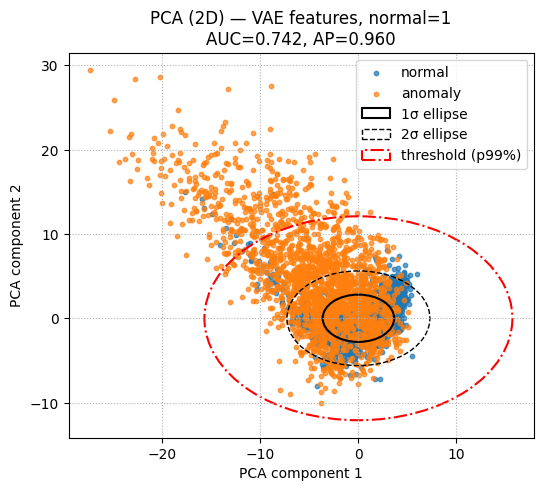

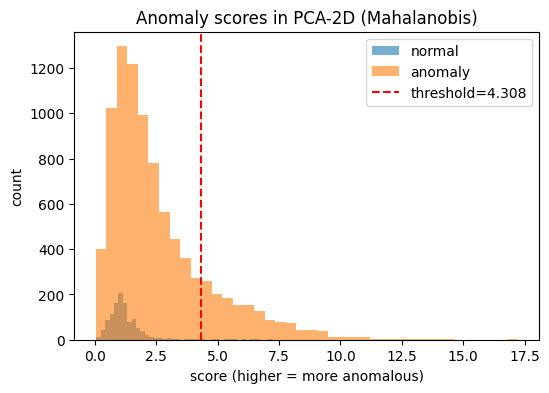

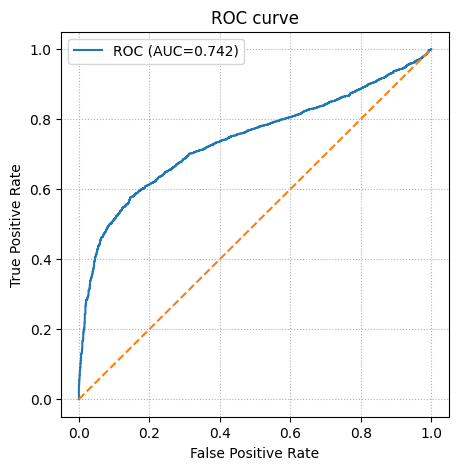

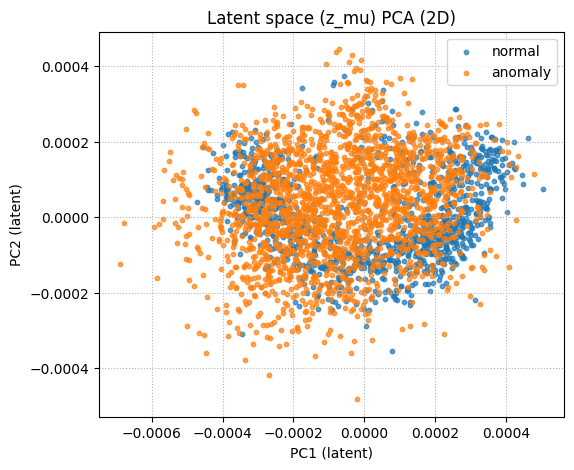

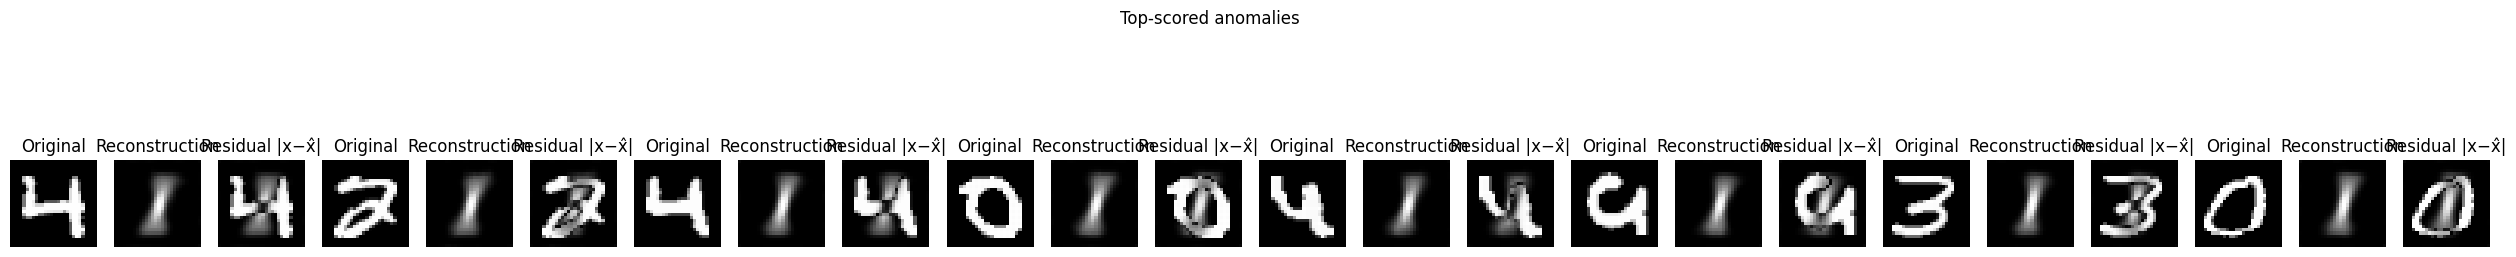

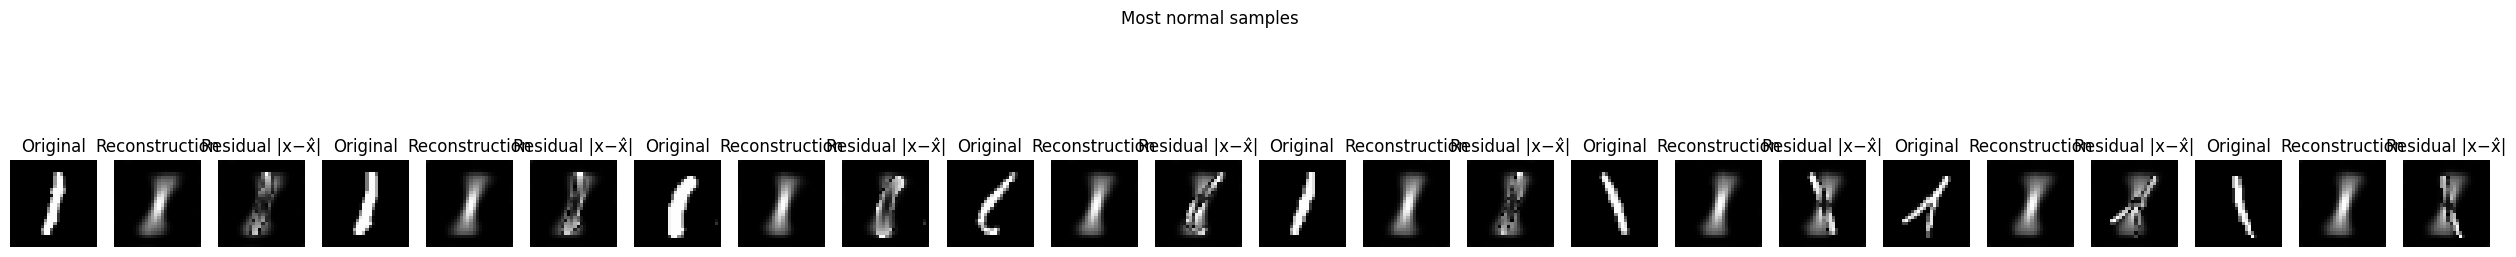

In [10]:
# ===== 可視化 =====
def sample_idx(n_total, n_pick):
    if n_total <= n_pick: return np.arange(n_total)
    return np.random.default_rng(SEED).choice(n_total, size=n_pick, replace=False)

# 1) PCA 散布図 + 1σ/2σ 楕円 + 閾値楕円
from matplotlib.patches import Ellipse
import numpy.linalg as LA
def plot_cov_ellipse(ax, mean, cov, nsig=1.0, **kwargs):
    vals, vecs = LA.eigh(cov); order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:,order]
    theta = np.degrees(np.arctan2(vecs[1,0], vecs[0,0]))
    width, height = 2*nsig*np.sqrt(vals)
    e = Ellipse(xy=mean, width=width, height=height, angle=theta, **kwargs)
    ax.add_patch(e)

Pn_s = Pn[sample_idx(len(Pn), SAMPLE_PER_CLASS)]
Pa_s = Pa[sample_idx(len(Pa), SAMPLE_PER_CLASS)]

fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(Pn_s[:,0], Pn_s[:,1], s=10, alpha=0.7, label="normal")
ax.scatter(Pa_s[:,0], Pa_s[:,1], s=10, alpha=0.7, label="anomaly")
plot_cov_ellipse(ax, mu_p, S, nsig=1.0, edgecolor="black", facecolor="none", linewidth=1.5, label="1σ ellipse")
plot_cov_ellipse(ax, mu_p, S, nsig=2.0, edgecolor="black", facecolor="none", linestyle="--", linewidth=1.0, label="2σ ellipse")
plot_cov_ellipse(ax, mu_p, S, nsig=thr, edgecolor="red", facecolor="none", linestyle="-.", linewidth=1.5, label=f"threshold (p{THRESH_PCT:.0f}%)")
ax.set_title(f"PCA (2D) — VAE features, normal={NORMAL_DIGIT}\nAUC={auc_v:.3f}, AP={ap_v:.3f}")
ax.set_xlabel("PCA component 1"); ax.set_ylabel("PCA component 2"); ax.legend(); ax.grid(True, linestyle=":")
plt.show()

# 2) スコアのヒストグラム
plt.figure(figsize=(6,4))
plt.hist(S_tn, bins=40, alpha=0.6, label="normal")
plt.hist(S_ta, bins=40, alpha=0.6, label="anomaly")
plt.axvline(thr, linestyle="--", color="red", label=f"threshold={thr:.3f}")
plt.title("Anomaly scores in PCA-2D (Mahalanobis)")
plt.xlabel("score (higher = more anomalous)"); plt.ylabel("count"); plt.legend(); plt.show()

# 3) ROC 曲線
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.title("ROC curve"); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.grid(True, linestyle=":"); plt.show()

# 4) 潜在 z_mu の可視化 (32次元 -> PCA-2D)
pca_z = PCA(n_components=2, random_state=SEED).fit(Zb_mu)
Zn2 = pca_z.transform(Zn_mu)
Za2 = pca_z.transform(Za_mu)
def _sample(X, n=SAMPLE_PER_CLASS):
    if len(X) <= n: return np.arange(len(X))
    return np.random.default_rng(SEED).choice(len(X), size=n, replace=False)
plt.figure(figsize=(6,5))
plt.scatter(Zn2[_sample(Zn2),0], Zn2[_sample(Zn2),1], s=10, alpha=0.7, label="normal")
plt.scatter(Za2[_sample(Za2),0], Za2[_sample(Za2),1], s=10, alpha=0.7, label="anomaly")
plt.title("Latent space (z_mu) PCA (2D)"); plt.xlabel("PC1 (latent)"); plt.ylabel("PC2 (latent)")
plt.legend(); plt.grid(True, linestyle=":"); plt.show()

# 5) ギャラリー: Original | Reconstruction | Residual
def show_gallery(X, Xhat, title, n=N_VIZ):
    X = X[:n]; Xhat = Xhat[:n]; resid = (X - Xhat).abs()
    plt.figure(figsize=(4*n, 4))
    for i in range(min(n, X.shape[0])):
        plt.subplot(1, 3*n, 3*i+1); plt.imshow(X[i,0], cmap="gray"); plt.axis("off"); plt.title("Original")
        plt.subplot(1, 3*n, 3*i+2); plt.imshow(Xhat[i,0], cmap="gray"); plt.axis("off"); plt.title("Reconstruction")
        plt.subplot(1, 3*n, 3*i+3); plt.imshow(resid[i,0], cmap="gray"); plt.axis("off"); plt.title("Residual |x−x̂|")
    plt.suptitle(title); plt.show()

# torch.topk を使用 (負のストライド問題を回避)
k_a = min(N_VIZ, len(S_ta)); k_n = min(N_VIZ, len(S_tn))
top_a  = torch.topk(torch.from_numpy(S_ta), k=k_a).indices
best_n = torch.topk(torch.from_numpy(-S_tn), k=k_n).indices
show_gallery(Xa[top_a],  Xa_hat[top_a],  "Top-scored anomalies")
show_gallery(Xn[best_n], Xn_hat[best_n], "Most normal samples")
